In [1]:
%matplotlib inline
import os
import glob
import xgboost
import operator
import numpy as np
from pylab import *
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.stats.weightstats as st
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler

In [2]:
## 导入数据
df = pd.read_excel(r"F:\Desktop\Kidney\51例\标准化特征.xlsx")
X_data = df.iloc[:,2:13]
X_data

,target,original_firstorder_Skewness,original_glrlm_ShortRunEmphasis,original_glrlm_RunLengthNonUniformityNormalized,original_glcm_Idmn,original_gldm_DependenceVariance,original_glszm_GrayLevelNonUniformityNormalized,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_shape_Sphericity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_LargeAreaLowGrayLevelEmphasis
0,1,0.071558,0.362205,0.340477,0.627939,0.212399,0.654739,0.129155,0.804306,0.111335,0.004705
1,1,0.110529,0.587411,0.506435,0.769271,0.408036,0.209295,0.149663,0.297115,0.449537,0.020444
2,1,0.041602,0.289311,0.223878,0.830453,0.531002,0.498853,0.107441,0.624166,0.293262,0.028267
3,1,0.089251,0.334940,0.265211,0.786587,0.510128,0.317639,0.103866,0.607895,0.197493,0.043225
4,1,0.091080,0.171747,0.132174,0.884085,0.426314,0.310754,0.033591,0.386906,0.249604,0.394110
5,1,0.128257,0.702744,0.633423,0.733315,0.122911,0.155737,0.078179,0.464130,0.369765,0.031010
6,1,0.096313,0.285342,0.233698,0.707691,0.399481,0.618509,0.161146,0.621103,0.267386,0.023239
7,1,0.028603,0.297181,0.225429,0.943527,0.644462,0.296356,0.007291,0.492117,0.232893,0.035788
8,1,0.117302,0.503626,0.453319,0.120587,0.060044,0.850757,0.362033,0.764301,0.059567,0.012791
9,1,0.073912,0.262207,0.195468,0.764846,0.582233,0.390881,0.159308,0.587034,0.204364,0.060365


In [275]:
X_data.to_excel(r"F:\Desktop\1.xlsx")

### 正态性检验

In [3]:
for i in X_data.columns[1:11]:
    print(i,'：') 
    zt = stats.shapiro(X_data[0:10][i])
    alpha = 0.05
    if(zt.pvalue < alpha): 
        print("正态性检验的统计量为：" + str(zt.statistic),"正态性检验的P值为：" + str(zt.pvalue),'P<0.05，拒绝原假设，不符合正态分布')
    else: 
        print("正态性检验的统计量为：" + str(zt.statistic),"正态性检验的P值为：" + str(zt.pvalue),'P>0.05，不能拒绝原假设，符合正态分布')

original_firstorder_Skewness ：
正态性检验的统计量为：0.9538730978965759 正态性检验的P值为：0.7143887877464294 P>0.05，不能拒绝原假设，符合正态分布
original_glrlm_ShortRunEmphasis ：
正态性检验的统计量为：0.8933149576187134 正态性检验的P值为：0.18473945558071136 P>0.05，不能拒绝原假设，符合正态分布
original_glrlm_RunLengthNonUniformityNormalized ：
正态性检验的统计量为：0.8955865502357483 正态性检验的P值为：0.19582915306091309 P>0.05，不能拒绝原假设，符合正态分布
original_glcm_Idmn ：
正态性检验的统计量为：0.7456164360046387 正态性检验的P值为：0.0031559618655592203 P<0.05，拒绝原假设，不符合正态分布
original_gldm_DependenceVariance ：
正态性检验的统计量为：0.9263687133789062 正态性检验的P值为：0.41313934326171875 P>0.05，不能拒绝原假设，符合正态分布
original_glszm_GrayLevelNonUniformityNormalized ：
正态性检验的统计量为：0.9362633228302002 正态性检验的P值为：0.5122318267822266 P>0.05，不能拒绝原假设，符合正态分布
original_gldm_SmallDependenceLowGrayLevelEmphasis ：
正态性检验的统计量为：0.8609360456466675 正态性检验的P值为：0.07827220112085342 P>0.05，不能拒绝原假设，符合正态分布
original_shape_Sphericity ：
正态性检验的统计量为：0.9659124612808228 正态性检验的P值为：0.8505784273147583 P>0.05，不能拒绝原假设，符合正态分布
original_glszm_SizeZoneNonUniformityNormalize

### 曼惠特尼U检验（两独立样本差异性检验）

In [5]:
for i in X_data.columns[1:11]:
    print('特征',i,'：')
    fc = stats.mannwhitneyu(X_data[0:51].loc[X_data[0:51]["target"] == 1, i], X_data[0:51].loc[X_data[0:51]["target"] == 0, i],alternative='two-sided')
    print("Mann-Whitney 检验的统计量为" + str(fc.statistic))
    print("Mann-Whitney 检验的P,值为" + str("%d"%fc.pvalue))
    
    alpha = 0.05
    if(fc.pvalue < alpha): 
        print('P<0.05，拒绝原假设，两总体有显著差异。')
    else: 
        print('P>0.05，不能拒绝原假设，两总体无显著差异。')

特征 original_firstorder_Skewness ：
Mann-Whitney 检验的统计量为210.0
Mann-Whitney 检验的P值为0
P>0.05，不能拒绝原假设，两总体无显著差异。
特征 original_glrlm_ShortRunEmphasis ：
Mann-Whitney 检验的统计量为171.0
Mann-Whitney 检验的P值为0
P>0.05，不能拒绝原假设，两总体无显著差异。
特征 original_glrlm_RunLengthNonUniformityNormalized ：
Mann-Whitney 检验的统计量为171.0
Mann-Whitney 检验的P值为0
P>0.05，不能拒绝原假设，两总体无显著差异。
特征 original_glcm_Idmn ：
Mann-Whitney 检验的统计量为243.0
Mann-Whitney 检验的P值为0
P>0.05，不能拒绝原假设，两总体无显著差异。
特征 original_gldm_DependenceVariance ：
Mann-Whitney 检验的统计量为238.0
Mann-Whitney 检验的P值为0
P>0.05，不能拒绝原假设，两总体无显著差异。
特征 original_glszm_GrayLevelNonUniformityNormalized ：
Mann-Whitney 检验的统计量为263.0
Mann-Whitney 检验的P值为0
P>0.05，不能拒绝原假设，两总体无显著差异。
特征 original_gldm_SmallDependenceLowGrayLevelEmphasis ：
Mann-Whitney 检验的统计量为204.0
Mann-Whitney 检验的P值为0
P>0.05，不能拒绝原假设，两总体无显著差异。
特征 original_shape_Sphericity ：
Mann-Whitney 检验的统计量为191.0
Mann-Whitney 检验的P值为0
P>0.05，不能拒绝原假设，两总体无显著差异。
特征 original_glszm_SizeZoneNonUniformityNormalized ：
Mann-Whitney 检验的统计量为221.0
Mann-Whitney 检验的P值为0


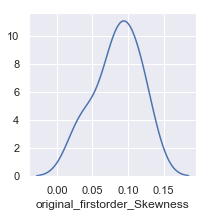

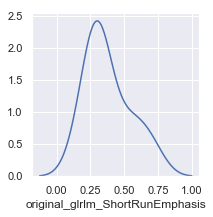

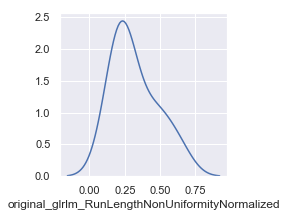

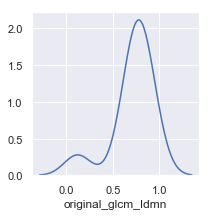

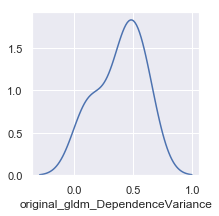

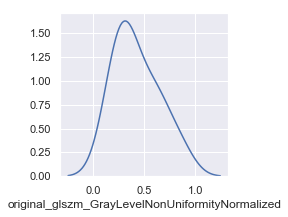

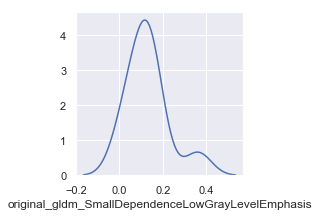

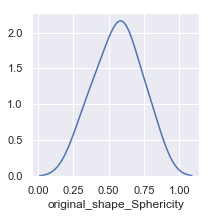

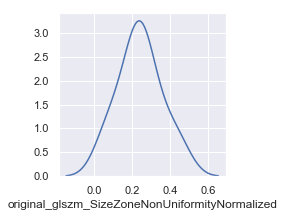

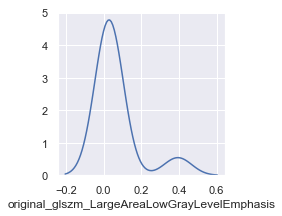

In [233]:
#查看数据集分布
for i in X_data.columns[1:11]: 
    #fig, axes = plt.subplots(ncols=10)
    #fig.set_size_inches(10, 5)
    plt.figure(figsize=(3, 3))
    sns.kdeplot(X_data[0:51].loc[X_data[0:51]["target"] == 1, i],legend=False)
    plt.xlabel(i,fontsize=12)
    plt.show()
    #plt.subplots_adjust(wspace=0.2)

### 方差齐性检验

In [235]:
for i in X_data.columns[1:11]:
    print('特征',i)
    W, levene_P = stats.levene(X_data[0:51].loc[X_data[0:51]["target"] == 1, i], X_data[0:51].loc[X_data[0:51]["target"] == 0, i], center='mean')
    #print("Levene's方差齐性检验的W统计量为" + str(W))
    print("Levene's方差齐性检验的P值为" + str(levene_P))

    alpha = 0.05
    if(levene_P < alpha): 
        print('P<0.05，拒绝原假设，两总体方差有显著差异，不满足方差齐性。')
    else: 
        print('P>0.05，不能拒绝原假设，两总体方差无显著差异，满足方差齐性。')

特征 original_firstorder_Skewness
Levene's方差齐性检验的P值为0.8085714767547119
P>0.05，不能拒绝原假设，两总体方差无显著差异，满足方差齐性。
特征 original_glrlm_ShortRunEmphasis
Levene's方差齐性检验的P值为0.5627105949349853
P>0.05，不能拒绝原假设，两总体方差无显著差异，满足方差齐性。
特征 original_glrlm_RunLengthNonUniformityNormalized
Levene's方差齐性检验的P值为0.6150411828363028
P>0.05，不能拒绝原假设，两总体方差无显著差异，满足方差齐性。
特征 original_glcm_Idmn
Levene's方差齐性检验的P值为0.4685296306839365
P>0.05，不能拒绝原假设，两总体方差无显著差异，满足方差齐性。
特征 original_gldm_DependenceVariance
Levene's方差齐性检验的P值为0.6022983294652546
P>0.05，不能拒绝原假设，两总体方差无显著差异，满足方差齐性。
特征 original_glszm_GrayLevelNonUniformityNormalized
Levene's方差齐性检验的P值为0.0020055598269307358
P<0.05，拒绝原假设，两总体方差有显著差异，不满足方差齐性。
特征 original_gldm_SmallDependenceLowGrayLevelEmphasis
Levene's方差齐性检验的P值为0.4548115262731788
P>0.05，不能拒绝原假设，两总体方差无显著差异，满足方差齐性。
特征 original_shape_Sphericity
Levene's方差齐性检验的P值为0.2477463289666926
P>0.05，不能拒绝原假设，两总体方差无显著差异，满足方差齐性。
特征 original_glszm_SizeZoneNonUniformityNormalized
Levene's方差齐性检验的P值为0.19225175602473255
P>0.05，不能拒绝原假设，两总体方差无显著差异，满足方差齐性。

### t检验

In [237]:
for i in X_data.columns[1:11]:
    print('特征',i,'：')
    t, p_two, df = st.ttest_ind(X_data[0:51].loc[X_data[0:51]["target"] == 1, i], X_data[0:51].loc[X_data[0:51]["target"] == 0, i])

    #print('t=' + str(t))
    print('P值=' + str(p_two))
    #print('自由度=' + str(df))

    alpha = 0.05
    if(p_two < alpha): 
        print('P<0.5，拒绝原假设，平均值有显著差异。')
    else: 
        print('P>0.5，不能拒绝原假设，平均值无显著差异。')

特征 original_firstorder_Skewness ：
P值=0.9442107662400765
P>0.5，不能拒绝原假设，平均值无显著差异。
特征 original_glrlm_ShortRunEmphasis ：
P值=0.45884526281613536
P>0.5，不能拒绝原假设，平均值无显著差异。
特征 original_glrlm_RunLengthNonUniformityNormalized ：
P值=0.47419468570213463
P>0.5，不能拒绝原假设，平均值无显著差异。
特征 original_glcm_Idmn ：
P值=0.9177569757817347
P>0.5，不能拒绝原假设，平均值无显著差异。
特征 original_gldm_DependenceVariance ：
P值=0.7651860620419467
P>0.5，不能拒绝原假设，平均值无显著差异。
特征 original_glszm_GrayLevelNonUniformityNormalized ：
P值=0.03082554448226451
P<0.5，拒绝原假设，平均值有显著差异。
特征 original_gldm_SmallDependenceLowGrayLevelEmphasis ：
P值=0.7163918009863006
P>0.5，不能拒绝原假设，平均值无显著差异。
特征 original_shape_Sphericity ：
P值=0.6714723692300579
P>0.5，不能拒绝原假设，平均值无显著差异。
特征 original_glszm_SizeZoneNonUniformityNormalized ：
P值=0.7341759483994745
P>0.5，不能拒绝原假设，平均值无显著差异。
特征 original_glszm_LargeAreaLowGrayLevelEmphasis ：
P值=0.6999322303346636
P>0.5，不能拒绝原假设，平均值无显著差异。


In [201]:
stats.bartlett(X_data[0:51].loc[X_data[0:51]["target"] == 1, "original_firstorder_Skewness"], X_data[0:51].loc[X_data[0:51]["target"] == 0, "original_firstorder_Skewness"])

BartlettResult(statistic=0.0001942949491778022, pvalue=0.9888786693345528)

In [202]:
stats.ttest_ind(X_data[0:51].loc[X_data[0:51]["target"] == 1, "original_firstorder_Skewness"], X_data[0:51].loc[X_data[0:51]["target"] == 0, "original_firstorder_Skewness"], equal_var=True)

Ttest_indResult(statistic=-0.07033820047324134, pvalue=0.9442107662400765)

### 三分期差异性K-W检验

In [363]:
#高级别
p1=[]
for i in X_data.columns[1:11]:
    s,p=stats.kruskal(X_data[0:51].loc[X_data[0:51]["target"] == 1, i],X_data[51:102].loc[X_data[51:102]["target"] == 1, i],X_data[102:153].loc[X_data[102:153]["target"] == 1, i])
    p1.append(p)
d = pd.DataFrame(p1,index=X_data.columns[1:11],columns=["p_value"])
d = d.sort_values(by='p_value',ascending=True,axis=0)
d

,p_value
original_glcm_Idmn,0.008881
original_gldm_DependenceVariance,0.036907
original_glrlm_RunLengthNonUniformityNormalized,0.046197
original_glrlm_ShortRunEmphasis,0.050304
original_firstorder_Skewness,0.070720
original_glszm_SizeZoneNonUniformityNormalized,0.462864
original_glszm_LargeAreaLowGrayLevelEmphasis,0.478655
original_gldm_SmallDependenceLowGrayLevelEmphasis,0.613220
original_shape_Sphericity,0.703099
original_glszm_GrayLevelNonUniformityNormalized,0.983366


In [366]:
#低级别
p1=[]
for i in X_data.columns[1:11]:
    s,p=stats.kruskal(X_data[0:51].loc[X_data[0:51]["target"] == 0, i],X_data[51:102].loc[X_data[51:102]["target"] == 0, i],X_data[102:153].loc[X_data[102:153]["target"] == 0, i])
    p1.append(str(p))
d = pd.DataFrame(p1,index=X_data.columns[1:11],columns=["p_value"])
d = d.sort_values(by='p_value',ascending=True,axis=0)
d

,p_value
original_glrlm_ShortRunEmphasis,0.0001444182280878144
original_glszm_SizeZoneNonUniformityNormalized,0.0006584182409703862
original_firstorder_Skewness,0.003157670860605334
original_glszm_GrayLevelNonUniformityNormalized,0.025609977113198817
original_gldm_SmallDependenceLowGrayLevelEmphasis,0.08727271976524181
original_shape_Sphericity,0.1010048263340035
original_glszm_LargeAreaLowGrayLevelEmphasis,0.4275244428062164
original_gldm_DependenceVariance,2.2203061111959727e-07
original_glcm_Idmn,6.337373409421018e-09
original_glrlm_RunLengthNonUniformityNormalized,8.079807586233175e-05


Text(0.5,0,'P_value')

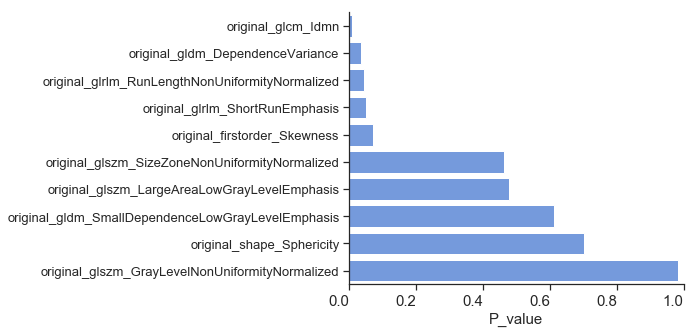

In [364]:
plt.figure(figsize = (6,5))
sns.set(style="ticks")
ax=sns.barplot(y=d.index, x="p_value", data=d, palette=["#6495ED"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(0,1)
plt.xticks(rotation=0,ha='right',fontsize=15) 
plt.yticks(rotation=0,ha='right',fontsize=13) 
plt.xlabel('P_value',fontsize=15) 

###  高核分级在不同分期之间的差异性检验

In [4]:
#cmp和np差异性检验M-U检验
p_cmp_np=[]
for i in X_data.columns[1:11]:
    m, p=stats.mannwhitneyu(X_data[0:51].loc[X_data[0:51]["target"] == 1, i],X_data[102:153].loc[X_data[102:153]["target"] == 1, i])
    p_cmp_np.append(p)
a = pd.DataFrame(p_cmp_np,index=X_data.columns[1:11],columns=["p_value"])
a['stage']='CMP_NP'
a

,p_value,stage
original_firstorder_Skewness,0.022577,CMP_NP
original_glrlm_ShortRunEmphasis,0.153745,CMP_NP
original_glrlm_RunLengthNonUniformityNormalized,0.213678,CMP_NP
original_glcm_Idmn,0.311588,CMP_NP
original_gldm_DependenceVariance,0.080986,CMP_NP
original_glszm_GrayLevelNonUniformityNormalized,0.454861,CMP_NP
original_gldm_SmallDependenceLowGrayLevelEmphasis,0.454861,CMP_NP
original_shape_Sphericity,0.338792,CMP_NP
original_glszm_SizeZoneNonUniformityNormalized,0.172352,CMP_NP
original_glszm_LargeAreaLowGrayLevelEmphasis,0.366865,CMP_NP


In [5]:
#ep和np差异性检验M-U检验
p_ep_np=[]
for i in X_data.columns[1:11]:
    m, p=stats.mannwhitneyu(X_data[51:102].loc[X_data[51:102]["target"] == 1, i],X_data[102:153].loc[X_data[102:153]["target"] == 1, i])
    p_ep_np.append(p)
b=pd.DataFrame(p_ep_np,index=X_data.columns[1:11],columns=["p_value"])
b['stage']='EP_NP'
b

,p_value,stage
original_firstorder_Skewness,0.032011,EP_NP
original_glrlm_ShortRunEmphasis,0.044487,EP_NP
original_glrlm_RunLengthNonUniformityNormalized,0.037831,EP_NP
original_glcm_Idmn,0.002898,EP_NP
original_gldm_DependenceVariance,0.052055,EP_NP
original_glszm_GrayLevelNonUniformityNormalized,0.484925,EP_NP
original_gldm_SmallDependenceLowGrayLevelEmphasis,0.260261,EP_NP
original_shape_Sphericity,0.236338,EP_NP
original_glszm_SizeZoneNonUniformityNormalized,0.454861,EP_NP
original_glszm_LargeAreaLowGrayLevelEmphasis,0.236338,EP_NP


In [6]:
#cmp和ep差异性检验
p_cmp_ep=[]
for i in X_data.columns[1:11]:
    m, p=stats.mannwhitneyu(X_data[0:51].loc[X_data[0:51]["target"] == 1, i],X_data[51:102].loc[X_data[51:102]["target"] == 1, i])
    p_cmp_ep.append(p)
c=pd.DataFrame(p_cmp_ep,index=X_data.columns[1:11],columns=["p_value"])
c['stage']='CMP_EP'
c

,p_value,stage
original_firstorder_Skewness,0.395668,CMP_EP
original_glrlm_ShortRunEmphasis,0.015605,CMP_EP
original_glrlm_RunLengthNonUniformityNormalized,0.012874,CMP_EP
original_glcm_Idmn,0.008629,CMP_EP
original_gldm_DependenceVariance,0.012874,CMP_EP
original_glszm_GrayLevelNonUniformityNormalized,0.454861,CMP_EP
original_gldm_SmallDependenceLowGrayLevelEmphasis,0.172352,CMP_EP
original_shape_Sphericity,0.311588,CMP_EP
original_glszm_SizeZoneNonUniformityNormalized,0.136518,CMP_EP
original_glszm_LargeAreaLowGrayLevelEmphasis,0.120661,CMP_EP


In [10]:
d = pd.concat([a,b,c])
d

,p_value,stage
original_firstorder_Skewness,0.022577,CMP_NP
original_glrlm_ShortRunEmphasis,0.153745,CMP_NP
original_glrlm_RunLengthNonUniformityNormalized,0.213678,CMP_NP
original_glcm_Idmn,0.311588,CMP_NP
original_gldm_DependenceVariance,0.080986,CMP_NP
original_glszm_GrayLevelNonUniformityNormalized,0.454861,CMP_NP
original_gldm_SmallDependenceLowGrayLevelEmphasis,0.454861,CMP_NP
original_shape_Sphericity,0.338792,CMP_NP
original_glszm_SizeZoneNonUniformityNormalized,0.172352,CMP_NP
original_glszm_LargeAreaLowGrayLevelEmphasis,0.366865,CMP_NP


In [12]:
len(d.index)

30

Text(0,0.5,'P_value')

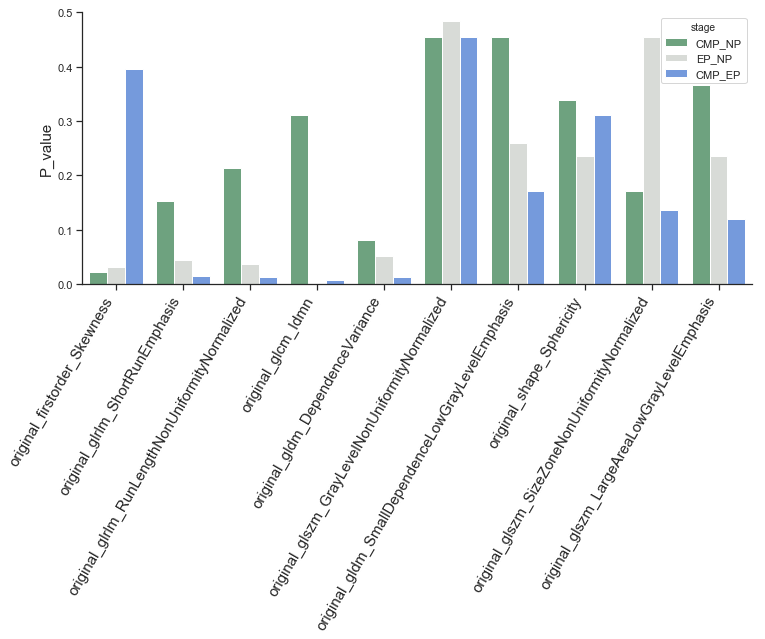

In [9]:
plt.figure(figsize = (12,5))
sns.set(style="ticks")
ax=sns.barplot(x=d.index, y="p_value", hue="stage", data=d, palette=["#65ab7c","#d8dcd6","#6495ED"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0,0.5)
plt.xticks(rotation=60,ha='right',fontsize=15) 
plt.ylabel('P_value',fontsize=15) 

In [5]:
d = pd.read_excel(r"F:\Desktop\1.xlsx")
d

,Unnamed: 0,value,patient
0,original_firstorder_10Percentile,1.000000,kongfanjiao
1,original_firstorder_90Percentile,1.000000,kongfanjiao
2,original_firstorder_Energy,1.000000,kongfanjiao
3,original_firstorder_Entropy,1.000000,kongfanjiao
4,original_firstorder_InterquartileRange,1.000000,kongfanjiao
...,...,...,...
67,original_firstorder_RootMeanSquared,0.156669,shixingfeng
68,original_firstorder_Skewness,1.000000,shixingfeng
69,original_firstorder_TotalEnergy,0.192594,shixingfeng
70,original_firstorder_Uniformity,0.685894,shixingfeng


Text(0,0.5,'value')

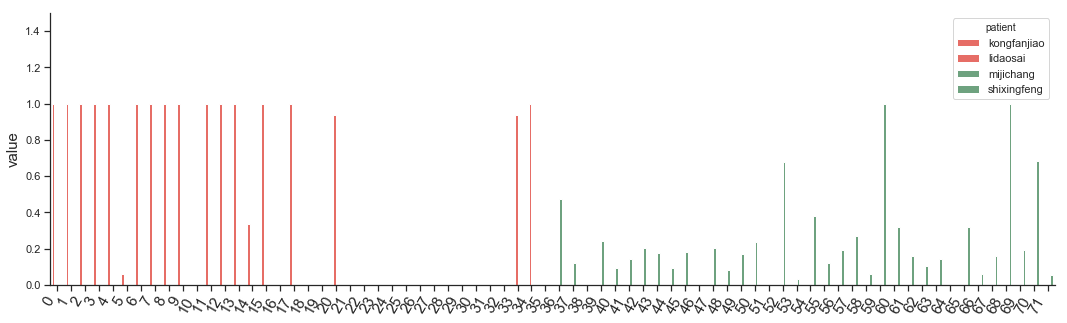

In [6]:
plt.figure(figsize = (18,5))
sns.set(style="ticks")
ax=sns.barplot(x=d.index, y="value", hue="patient", data=d, palette=["#fc5a50","#fc5a50","#65ab7c","#65ab7c"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0,1.5)
plt.xticks(rotation=60,ha='right',fontsize=15) 
plt.ylabel('value',fontsize=15) 

### 低核分级在不同分期之间的差异性检验

In [322]:
#cmp和np差异性检验M-U检验
p_cmp_np=[]
for i in X_data.columns[1:11]:
    m, p=stats.mannwhitneyu(X_data[0:51].loc[X_data[0:51]["target"] == 0, i],X_data[102:153].loc[X_data[102:153]["target"] == 0, i])
    p_cmp_np.append(p)
a = pd.DataFrame(p_cmp_np,index=X_data.columns[1:11],columns=["p_value"])
a['stage']='CMP_NP'
a

,p_value,stage
original_firstorder_Skewness,0.014999,CMP_NP
original_glrlm_ShortRunEmphasis,0.009480,CMP_NP
original_glrlm_RunLengthNonUniformityNormalized,0.006303,CMP_NP
original_glcm_Idmn,0.393985,CMP_NP
original_gldm_DependenceVariance,0.004966,CMP_NP
original_glszm_GrayLevelNonUniformityNormalized,0.031155,CMP_NP
original_gldm_SmallDependenceLowGrayLevelEmphasis,0.288955,CMP_NP
original_shape_Sphericity,0.288955,CMP_NP
original_glszm_SizeZoneNonUniformityNormalized,0.041438,CMP_NP
original_glszm_LargeAreaLowGrayLevelEmphasis,0.172087,CMP_NP


In [323]:
#ep和np差异性检验M-U检验
p_ep_np=[]
for i in X_data.columns[1:11]:
    m, p=stats.mannwhitneyu(X_data[51:102].loc[X_data[51:102]["target"] == 0, i],X_data[102:153].loc[X_data[102:153]["target"] == 0, i])
    p_ep_np.append(p)
b=pd.DataFrame(p_ep_np,index=X_data.columns[1:11],columns=["p_value"])
b['stage']='EP_NP'
b

,p_value,stage
original_firstorder_Skewness,7.107227e-04,EP_NP
original_glrlm_ShortRunEmphasis,2.925224e-02,EP_NP
original_glrlm_RunLengthNonUniformityNormalized,2.925224e-02,EP_NP
original_glcm_Idmn,3.558306e-08,EP_NP
original_gldm_DependenceVariance,8.603944e-04,EP_NP
original_glszm_GrayLevelNonUniformityNormalized,5.673843e-03,EP_NP
original_gldm_SmallDependenceLowGrayLevelEmphasis,5.961256e-02,EP_NP
original_shape_Sphericity,5.431248e-02,EP_NP
original_glszm_SizeZoneNonUniformityNormalized,3.290986e-03,EP_NP
original_glszm_LargeAreaLowGrayLevelEmphasis,3.622645e-01,EP_NP


In [324]:
#cmp和ep差异性检验
p_cmp_ep=[]
for i in X_data.columns[1:11]:
    m, p=stats.mannwhitneyu(X_data[0:51].loc[X_data[0:51]["target"] == 0, i],X_data[51:102].loc[X_data[51:102]["target"] == 0, i])
    p_cmp_ep.append(p)
c=pd.DataFrame(p_cmp_ep,index=X_data.columns[1:11],columns=["p_value"])
c['stage']='CMP_EP'
c

,p_value,stage
original_firstorder_Skewness,6.298210e-02,CMP_EP
original_glrlm_ShortRunEmphasis,1.628160e-05,CMP_EP
original_glrlm_RunLengthNonUniformityNormalized,9.543140e-06,CMP_EP
original_glcm_Idmn,8.885033e-08,CMP_EP
original_gldm_DependenceVariance,3.208934e-08,CMP_EP
original_glszm_GrayLevelNonUniformityNormalized,1.516422e-01,CMP_EP
original_gldm_SmallDependenceLowGrayLevelEmphasis,1.684557e-02,CMP_EP
original_shape_Sphericity,2.359233e-02,CMP_EP
original_glszm_SizeZoneNonUniformityNormalized,3.002539e-04,CMP_EP
original_glszm_LargeAreaLowGrayLevelEmphasis,1.104441e-01,CMP_EP


In [325]:
d=pd.concat([a,b,c])
d

,p_value,stage
original_firstorder_Skewness,1.499891e-02,CMP_NP
original_glrlm_ShortRunEmphasis,9.479774e-03,CMP_NP
original_glrlm_RunLengthNonUniformityNormalized,6.303012e-03,CMP_NP
original_glcm_Idmn,3.939855e-01,CMP_NP
original_gldm_DependenceVariance,4.966174e-03,CMP_NP
original_glszm_GrayLevelNonUniformityNormalized,3.115547e-02,CMP_NP
original_gldm_SmallDependenceLowGrayLevelEmphasis,2.889548e-01,CMP_NP
original_shape_Sphericity,2.889548e-01,CMP_NP
original_glszm_SizeZoneNonUniformityNormalized,4.143771e-02,CMP_NP
original_glszm_LargeAreaLowGrayLevelEmphasis,1.720872e-01,CMP_NP


Text(0,0.5,'P_value')

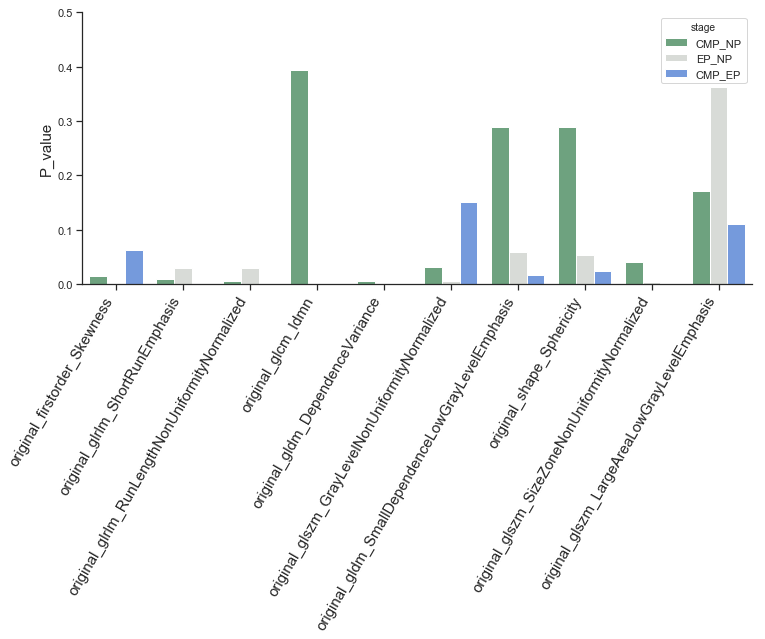

In [326]:
plt.figure(figsize = (12,5))
sns.set(style="ticks")
ax=sns.barplot(x=d.index, y="p_value", hue="stage", data=d,palette=["#65ab7c","#d8dcd6","#6495ED"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0,0.5)
plt.xticks(rotation=60,ha='right',fontsize=15) 
plt.ylabel('P_value',fontsize=15) 

### 不同分期特征取值热图

In [246]:
X_data.iloc[11:51,:]

,target,original_firstorder_Skewness,original_glrlm_ShortRunEmphasis,original_glrlm_RunLengthNonUniformityNormalized,original_glcm_Idmn,original_gldm_DependenceVariance,original_glszm_GrayLevelNonUniformityNormalized,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_shape_Sphericity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_LargeAreaLowGrayLevelEmphasis
11,0,0.109555,0.293144,0.227988,0.765681,0.501489,0.238697,0.114411,0.563132,0.152802,0.100307
12,0,0.071387,0.483251,0.408394,0.607624,0.326101,0.384863,0.182803,0.620861,0.250180,0.013678
13,0,0.135480,0.768672,0.705694,0.868375,0.293045,0.131885,0.017710,0.664006,0.614880,0.001472
14,0,0.090730,0.221228,0.173214,0.887271,0.490347,0.242689,0.070985,0.646039,0.098419,0.158901
15,0,0.066182,0.268224,0.214772,0.817487,0.461199,0.268352,0.068577,0.398846,0.110061,0.093265
16,0,0.146241,0.326996,0.275180,0.924377,0.358729,0.222181,0.057485,0.563367,0.186025,0.257549
17,0,0.125497,0.657897,0.606455,0.759211,0.044915,0.169526,0.064583,0.633105,0.307450,0.019416
18,0,0.085184,1.000000,1.000000,0.412793,0.024994,0.210470,0.346972,0.553791,0.610734,0.000000
19,0,0.047041,0.688295,0.617778,0.925971,0.155731,0.200886,0.009685,0.709499,0.845413,0.000583
20,0,0.074600,0.582909,0.501647,0.589890,0.308405,0.247943,0.265884,0.619342,0.479927,0.004697


In [97]:
len(X_data.iloc[112:153,:])

51

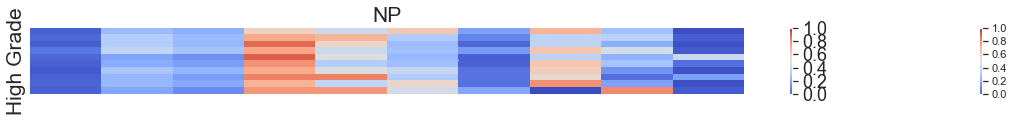

In [102]:
xlabel=list(df.columns[3:13])
plt.figure(figsize = (20,1.2))
sns.set()
sns.color_palette("coolwarm")
ax=sns.heatmap(X_data_1.iloc[102:112,:],vmin=0, vmax=1,xticklabels=False,yticklabels=False,cmap="coolwarm")
ax.set_title('NP',fontsize=21)
cb = ax.figure.colorbar(ax.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=18)  #设置刻度轴字体大小
plt.xticks(rotation=60,ha='right',fontsize=20)  #设置x轴字体大小、旋转角度
#plt.yticks(rotation=360,fontsize=15)  #设置y轴字体大小
#plt.xlabel('CMP',fontsize=20)  #设置x轴标签字体大小
plt.ylabel('High Grade',fontsize=21) 
#plt.setp(rotation=360, horizontalalignment='right')
plt.show()

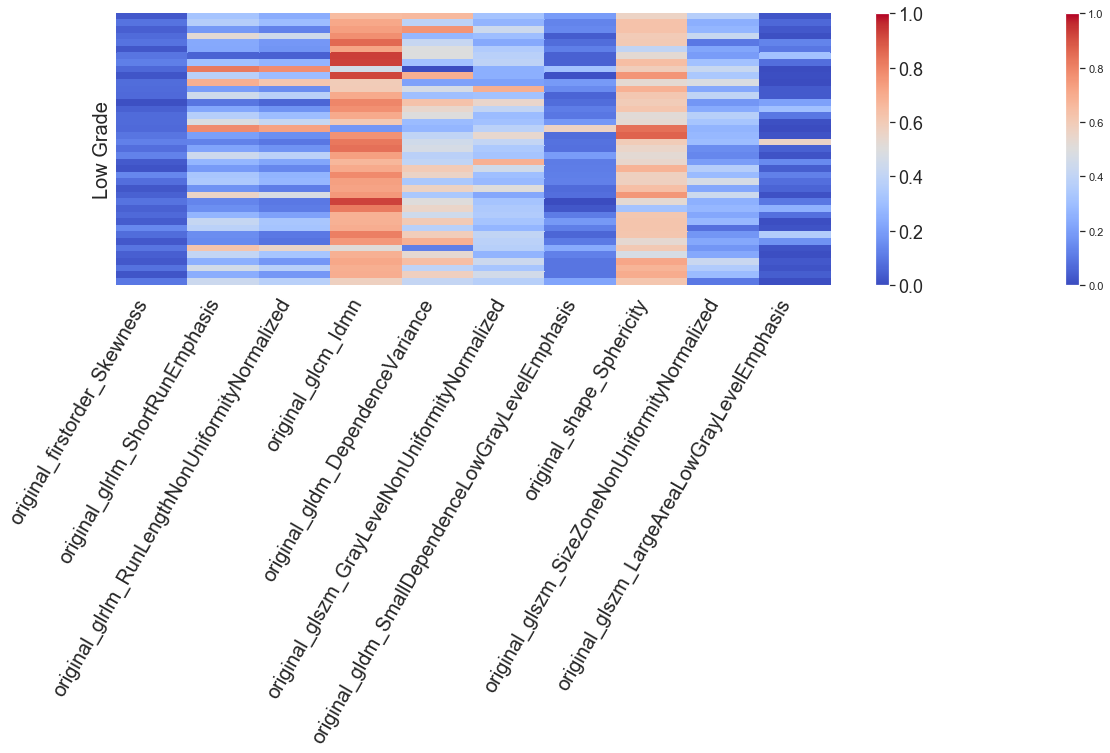

In [104]:
xlabel=list(df.columns[3:13])
plt.figure(figsize = (20,5))
sns.set()
sns.color_palette("coolwarm")
ax=sns.heatmap(X_data_1.iloc[112:153,:],vmin=0, vmax=1,xticklabels=xlabel,yticklabels=False,cmap="coolwarm")
cb = ax.figure.colorbar(ax.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=18)  #设置刻度轴字体大小
plt.xticks(rotation=60,ha='right',fontsize=20)  #设置x轴字体大小、旋转角度
plt.yticks(rotation=360,fontsize=20)  #设置y轴字体大小
#plt.xlabel('CMP',fontsize=20)  #设置x轴标签字体大小
plt.ylabel('Low Grade',fontsize=20) 
#plt.setp(rotation=360, horizontalalignment='right')
plt.show()

In [304]:
#导入数据
df_2 = pd.read_excel(r"F:\Desktop\Kidney\51例\特征均值.xlsx")
df_2.iloc[30:153,:]

,stage,target,mean
original_firstorder_Skewness,CMP,0,0.085633
original_glrlm_ShortRunEmphasis,CMP,0,0.430618
original_glrlm_RunLengthNonUniformityNormalized,CMP,0,0.369723
original_glcm_Idmn,CMP,0,0.710421
original_gldm_DependenceVariance,CMP,0,0.370270
original_glszm_GrayLevelNonUniformityNormalized,CMP,0,0.320759
original_gldm_SmallDependenceLowGrayLevelEmphasis,CMP,0,0.142821
original_shape_Sphericity,CMP,0,0.584495
original_glszm_SizeZoneNonUniformityNormalized,CMP,0,0.264362
original_glszm_LargeAreaLowGrayLevelEmphasis,CMP,0,0.088340


Text(0,0.5,'Mean')

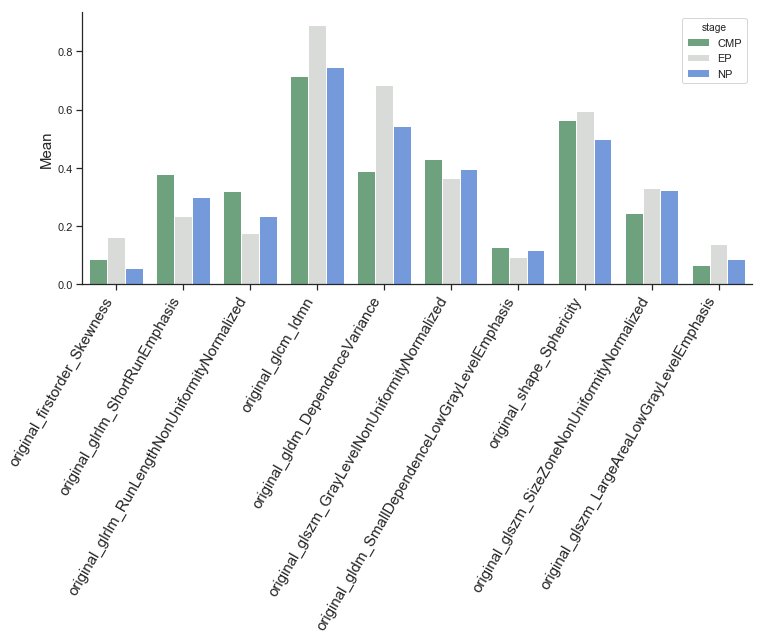

In [301]:
plt.figure(figsize = (12,5))
sns.set(style="ticks")
ax=sns.barplot(x=d.index, y="mean", hue="stage", data=df_2.iloc[0:30,:] ,palette=["#65ab7c","#d8dcd6","#6495ED"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=60,ha='right',fontsize=15) 
plt.ylabel('Mean',fontsize=15) 

Text(0,0.5,'Mean')

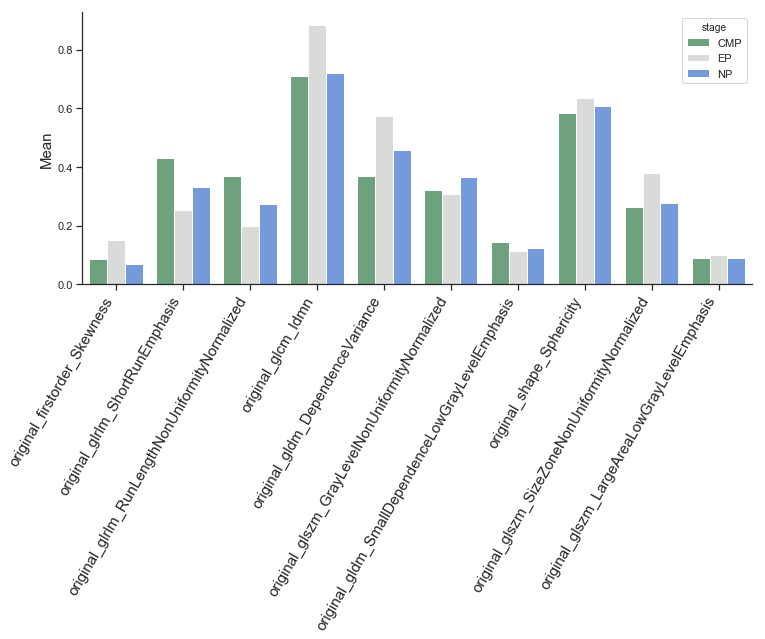

In [305]:
plt.figure(figsize = (12,5))
sns.set(style="ticks")
ax=sns.barplot(x=d.index, y="mean", hue="stage", data=df_2.iloc[30:153,:] ,palette=["#65ab7c","#d8dcd6","#6495ED"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=60,ha='right',fontsize=15) 
plt.ylabel('Mean',fontsize=15) 